## Homework 02-2: due 2022/03/31 23:59 (70%)

### - Tutorial : https://machinelearningmastery.com/pytorch-tutorial-develop-deep-learning-models/

### - After you go through the tutorials, you should be able to work on this assignment.

### - Please answer the following questions and work directly on this jupyter notebook.

### - Make sure the code can be run and show the result and figures properly.

### - Please write down your observation with markdown in this notebook briefly.



#### You will train a regression model in this part. The data is **Concrete Compressive Strength Dataset**, you can find the details of each column at https://archive.ics.uci.edu/ml/datasets/concrete+compressive+strength. In this part, please predict the **strength of concrete**.

In [63]:
# Import necessory modules
%matplotlib inline
import pandas as pd
from pandas import read_csv
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.preprocessing import MinMaxScaler
from numpy import vstack
from numpy import sqrt
from sklearn.metrics import mean_squared_error
from torch import Tensor
from torch.nn import Linear
from torch.nn import Sigmoid
from torch.nn import Tanh,Identity
from torch.nn import Module
from torch.optim import SGD
from torch.nn import MSELoss
from torch.nn.init import xavier_uniform_


In [64]:

# For reproduce the result
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

### 1. Define the model and dataset (10%)

#### 1.1 Please follow the tutorial to create a class ***ConcreteDataset***, for loading the data you need and also do the ***Min-Max scaling*** to the ***feature and label***. (5%)

In [65]:
class ConcreteDataset(Dataset):
    def __init__(self,path):
        df = pd.read_csv(path, header=1)
        normalized_df=df
        self.X = normalized_df.values[:, :-1].astype('float32')
        self.y = normalized_df.values[:, -1].astype('float32')
        self.X_scaler = MinMaxScaler()
        self.y_scaler = MinMaxScaler()
        self.X = self.X_scaler.fit_transform(self.X)
        self.y = self.y.reshape(len(self.y), 1)
        self.y = self.y_scaler.fit_transform(self.y)
    def __len__(self):
        return len(self.X)
    def __getitem__(self , idx):
        label = torch.tensor(self.y[idx], dtype=torch.float32)
        feature = torch.tensor(self.X[idx], dtype=torch.float32)
        return feature,label

        

#### 1.2 By following the tutorial, try to create a class ***MLP(Neural Network)*** with ***three hidden layers*** as your network architecture. Also, for the convenience of implementation, please set the numbers of hidden nodes and the activation functions as input variables to the foward functions.(5%) 

In [66]:
class MLP(nn.Module):
    def __init__(self,n_inputs,h1,h2,h3,func,out):
        super(MLP, self).__init__()
        # input to first hidden layer
        self.model = nn.Sequential(nn.Linear(n_inputs, h1),
                                   func,
                                   nn.Linear(h1, h2),
                                   func,
                                   nn.Linear(h2, h3),
                                   func,
                                   nn.Linear(h3, 1)
                                )
        self.out = out
    def forward(self,X):
        X = self.model(X)
        X = self.out(X)
        return X

### 2. Train the model (60%)

#### 2.1 Please load the ***train.csv/ validation.csv*** in ./data, and turn them into dataloader with batch size 64 and determine whether shuffle or not. (5%)

In [67]:
def prepare_data(path,shuffle):
    # load the dataset
    dataset = ConcreteDataset(path)
    # calculate split
    # prepare data loaders
    dl = DataLoader(dataset = dataset, batch_size=64, shuffle=shuffle,worker_init_fn=np.random.seed(0))
    
    return dl
 

In [68]:
train_path = './data/train.csv'
valid_path = './data/validation.csv'
train_dl = prepare_data(train_path,True)
valid_dl = prepare_data(valid_path,False)

#### 2.2 Create two MLP model from the table below and ***print the model*** (10%):
| | Hidden Layer 1| Hidden Layer 2| Hidden Layer 3| Activation in each hidden nodes | Activation for output |
|:---:|:---:|:---:|:---:|:---:|:---:|
|***Model1***| 256 | 64 | 8 | Tanh | Tanh |
|***Model2***| 64 | 16 | 8 | Sigmoid | Identity |

In [69]:
Model = {"model1":MLP(8,256,64,8,Tanh(),Tanh()),
         "model2":MLP(8,64,16,8,Sigmoid(),Identity())}

print(Model)




{'model1': MLP(
  (model): Sequential(
    (0): Linear(in_features=8, out_features=256, bias=True)
    (1): Tanh()
    (2): Linear(in_features=256, out_features=64, bias=True)
    (3): Tanh()
    (4): Linear(in_features=64, out_features=8, bias=True)
    (5): Tanh()
    (6): Linear(in_features=8, out_features=1, bias=True)
  )
  (out): Tanh()
), 'model2': MLP(
  (model): Sequential(
    (0): Linear(in_features=8, out_features=64, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=64, out_features=16, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=16, out_features=8, bias=True)
    (5): Sigmoid()
    (6): Linear(in_features=8, out_features=1, bias=True)
  )
  (out): Identity()
)}


#### 2.3 Train the above two models with the same hyperpameters below and do the validation in every epoch. Choose the appropriate type of loss function according to the task. (25%)
##### (Note. You should record the training/validation loss every epoch)


| | Learning rate | epochs | optimizer | momentum |
|:---:|:---:|:---:|:---:|:---:|
|***Hyperparameter***| 0.01 | 300 | SGD | 0.9 |

In [70]:


    epochs = 300 
    criterion = MSELoss()
    learningrate =0.01
    result={}
    # enumerate epochs
    for name, model in Model.items():
        optimizer = SGD(model.parameters(), lr=learningrate, momentum=0.9)
        result[name] = {"Training Loss":[], "Validation Loss":[]}
        for epoch in range(epochs):
            train_loss = 0
            valid_loss = 0
            print('running epoch: {}'.format(epoch))
            # enumerate mini batches
            for i, (inputs, label) in enumerate(train_dl):
                # clear the gradients
                optimizer.zero_grad()
                # compute the model output
                yhat = model(inputs)
                # calculate loss
                loss = criterion(yhat, label)
                # credit assignment
                loss.backward()
                # update model weights
                optimizer.step()
                train_loss += loss.detach().numpy()
            for i, (inputs, label) in enumerate(valid_dl):
                # clear the gradients
                with torch.no_grad():
                # compute the model output
                    yhat = model(inputs)
                    # calculate loss
                    loss = criterion(yhat, label)
                    valid_loss += loss.numpy()
            result[name]["Training Loss"].append(train_loss/len(train_dl))
            result[name]["Validation Loss"].append(valid_loss/len(valid_dl)) 
            print('\tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(train_loss, valid_loss))
        torch.save(model.state_dict(), 'model300epoch_{}.pth'.format(name))

running epoch: 0
	Training Loss: 0.763019 	Validation Loss: 0.102733
running epoch: 1
	Training Loss: 0.583672 	Validation Loss: 0.108570
running epoch: 2
	Training Loss: 0.577583 	Validation Loss: 0.101474
running epoch: 3
	Training Loss: 0.561380 	Validation Loss: 0.099573
running epoch: 4
	Training Loss: 0.556811 	Validation Loss: 0.098940
running epoch: 5
	Training Loss: 0.553579 	Validation Loss: 0.098017
running epoch: 6
	Training Loss: 0.548149 	Validation Loss: 0.097576
running epoch: 7
	Training Loss: 0.540288 	Validation Loss: 0.095658
running epoch: 8
	Training Loss: 0.532961 	Validation Loss: 0.094180
running epoch: 9
	Training Loss: 0.524747 	Validation Loss: 0.092466
running epoch: 10
	Training Loss: 0.516359 	Validation Loss: 0.090034
running epoch: 11
	Training Loss: 0.503208 	Validation Loss: 0.087472
running epoch: 12
	Training Loss: 0.487729 	Validation Loss: 0.084288
running epoch: 13
	Training Loss: 0.469461 	Validation Loss: 0.080619
running epoch: 14
	Training Lo

#### 2.4 Please include the plot that shows how the training/validation loss vary with the training epoch. Show the plots using the above two models and write down the observation. (5%)
##### Here is the example figure
![train_ex.png](https://github.com/tingyan08/Deep-Learning-and-Computer-Vision/blob/main/HW2/img/HW2-2.png?raw=true)

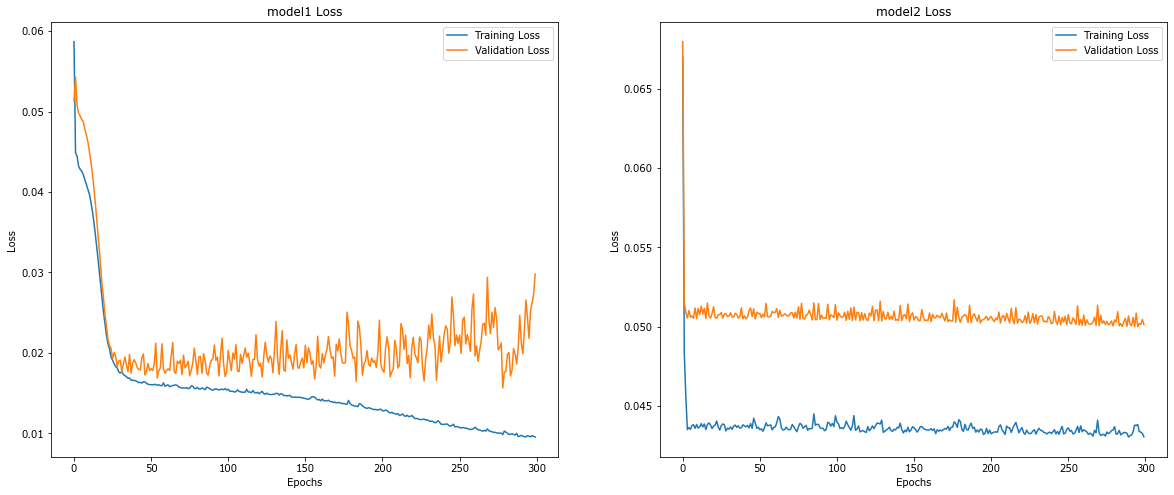

In [71]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
for i, (name, model) in enumerate(Model.items()):
    ax[i].set_title(f"{name} Loss")
    ax[i].set_xlabel("Epochs")
    ax[i].set_ylabel("Loss")
    ax[i].plot(range(len(result[name][f"Training Loss"])), result[name][f"Training Loss"], label=f"Training Loss")
    ax[i].plot(range(len(result[name][f"Validation Loss"])),  result[name][f"Validation Loss"], label=f"Validation Loss")
    ax[i].legend()
plt.show()


#### 2.5 From the observation of the previous question, please determine an appropriate epoch and retrain the two models to avoid overfitting. Also, draw the loss plot of two models and save the last model as ***model1.pth*** and ***model2.pth***. (10%)
##### (Note. You should reload the models and the optimizer, otherwise, you will resume from the previous stop.)

In [72]:
Model = {"model1":MLP(8,256,64,8,Tanh(),Tanh()),
         "model2":MLP(8,64,16,8,Sigmoid(),Identity())}

In [73]:
 
    epochs = 45 
    criterion = MSELoss()
    learningrate =0.01
    result={}
    # enumerate epochs
    for name, model in Model.items():
        optimizer = SGD(model.parameters(), lr=learningrate, momentum=0.9)
        result[name] = {"Training Loss":[], "Validation Loss":[]}
        for epoch in range(epochs):
            train_loss = 0
            valid_loss = 0
            print('running epoch: {}'.format(epoch))
            # enumerate mini batches
            for i, (inputs, label) in enumerate(train_dl):
                # clear the gradients
                optimizer.zero_grad()
                # compute the model output
                yhat = model(inputs)
                # calculate loss
                loss = criterion(yhat, label)
                # credit assignment
                loss.backward()
                # update model weights
                optimizer.step()
                train_loss += loss.detach().numpy()
            for i, (inputs, label) in enumerate(valid_dl):
                # clear the gradients
                with torch.no_grad():
                # compute the model output
                    yhat = model(inputs)
                    # calculate loss
                    loss = criterion(yhat, label)
                    valid_loss += loss.numpy()
            result[name]["Training Loss"].append(train_loss/len(train_dl))
            result[name]["Validation Loss"].append(valid_loss/len(valid_dl)) 
            print('\tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(train_loss, valid_loss))
        torch.save(model.state_dict(), 'model45epoch_{}.pth'.format(name))

running epoch: 0
	Training Loss: 0.757923 	Validation Loss: 0.121304
running epoch: 1
	Training Loss: 0.639850 	Validation Loss: 0.097224
running epoch: 2
	Training Loss: 0.547575 	Validation Loss: 0.093681
running epoch: 3
	Training Loss: 0.521763 	Validation Loss: 0.091598
running epoch: 4
	Training Loss: 0.504884 	Validation Loss: 0.086889
running epoch: 5
	Training Loss: 0.484209 	Validation Loss: 0.082883
running epoch: 6
	Training Loss: 0.465076 	Validation Loss: 0.078922
running epoch: 7
	Training Loss: 0.443018 	Validation Loss: 0.073878
running epoch: 8
	Training Loss: 0.416142 	Validation Loss: 0.068702
running epoch: 9
	Training Loss: 0.387542 	Validation Loss: 0.063472
running epoch: 10
	Training Loss: 0.362740 	Validation Loss: 0.057882
running epoch: 11
	Training Loss: 0.337307 	Validation Loss: 0.053178
running epoch: 12
	Training Loss: 0.315419 	Validation Loss: 0.048313
running epoch: 13
	Training Loss: 0.297025 	Validation Loss: 0.044722
running epoch: 14
	Training Lo

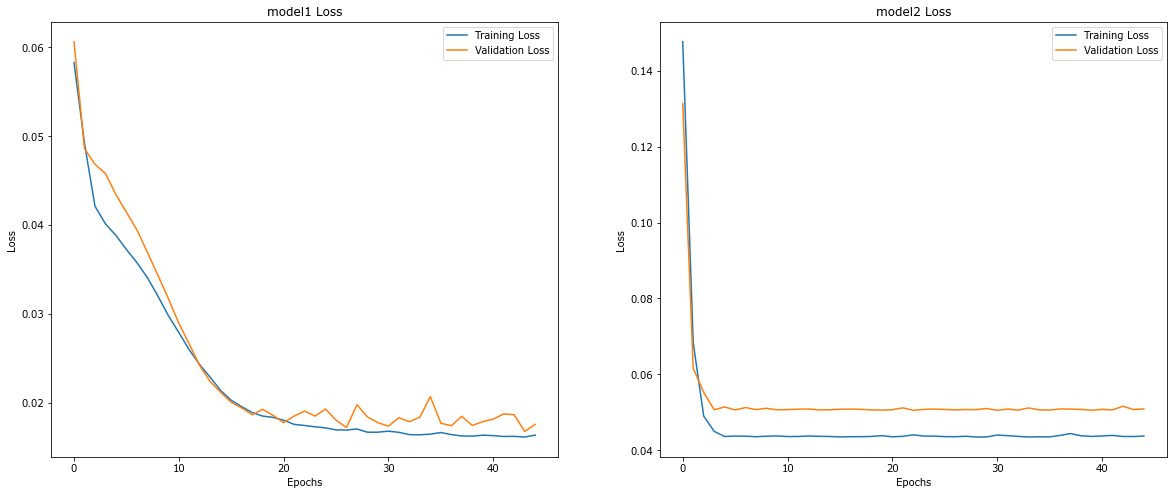

In [74]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
for i, (name, model) in enumerate(Model.items()):
    ax[i].set_title(f"{name} Loss")
    ax[i].set_xlabel("Epochs")
    ax[i].set_ylabel("Loss")
    ax[i].plot(range(len(result[name][f"Training Loss"])), result[name][f"Training Loss"], label=f"Training Loss")
    ax[i].plot(range(len(result[name][f"Validation Loss"])),  result[name][f"Validation Loss"], label=f"Validation Loss")
    ax[i].legend()
plt.show()


#### 2.6 Please load the checkpoints saved from previous question and calculate the mean squared error on test dataset for two models respectively. Also, make a dataframe with target and prediction like below and save it as ***regression.csv*** (5%)
|Target|Model1|Model2|
|:---:|:---:|:---:|
|24.05|26.35|27.04|
|21.67|32.78|21.95|

In [75]:
Model = {"model1":MLP(8,256,64,8,Tanh(),Tanh()),
         "model2":MLP(8,64,16,8,Sigmoid(),Identity())}

In [77]:
test_path = './data/test.csv'
test_ds = ConcreteDataset(test_path)
test_dl = DataLoader(test_ds, batch_size=len(test_ds), shuffle=False)
result={}
for name, model in Model.items():
    for X, y in test_dl:
        model.load_state_dict(torch.load(f"model45epoch_{name}.pth"))
        with torch.no_grad():
            pred = model(X)
            result["Target"] = test_ds.y_scaler.inverse_transform(y).squeeze()
            result[name] = test_ds.y_scaler.inverse_transform(pred).squeeze()
        print(f"Mean Squared Error ({name}): ", mean_squared_error(result["Target"], result[name]))

Mean Squared Error (model1):  119.69784223439484
Mean Squared Error (model2):  250.14025617923343


In [78]:
out = pd.DataFrame(result)
out.to_csv("regression.csv")